In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

!pip install -U aeon
!pip install -U imbalanced-learn
from sklearn.linear_model import ElasticNet
from aeon.datasets import load_classification, load_arrow_head
from aeon.classification.deep_learning  import CNNClassifier, MLPClassifier, TapNetClassifier, FCNClassifier
# from torchvision.ops import MLP
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler


  Using cached aeon-0.7.1-py3-none-any.whl (53.9 MB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl (9.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

In [4]:
def load_dataset(PATH):
  loaded_data = np.load(PATH)
  X_train = loaded_data['X_train']
  X_test = loaded_data['X_test']
  y_train = loaded_data['y_train']
  y_test = loaded_data['y_test']
  indices = loaded_data['indices']
  X_train_deq = X_train[indices]
  y_train_deq = y_train[indices]

  return X_train, X_test, X_train_deq, y_train.reshape(y_train.shape[0]), y_test.reshape(y_test.shape[0]), y_train_deq.reshape(y_train_deq.shape[0])

gpds = load_dataset('/content/gunpoint.npz')
gpds[0].shape , gpds[3].shape

((160, 1, 150), (160,))

In [6]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_test,y_train,y_test = gpds[0],gpds[1],gpds[3],gpds[4]
X_train.shape, X_test.shape, type(X_train[0][0][0]), type(y_train[0])

((160, 1, 150), (40, 1, 150), numpy.float64, numpy.int64)

In [7]:
print(X_train.size)
print(np.shape(X_train))
#number of classes
print(len(np.unique(y_train)))
n_classes=len(np.unique(y_train))

24000
(160, 1, 150)
2


**BUILD THE MODEL**

In [8]:
import keras
from keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs  # Skip connection

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res  # Skip connection


In [9]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    n_classes=2
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Output layer with sigmoid activation for binary classification
    return keras.Model(inputs, outputs)




In [10]:
from keras.callbacks import ReduceLROnPlateau

# Normalize
mean = X_train.mean(axis=0, keepdims=True)
std = X_train.std(axis=0, keepdims=True) + 1e-9
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

n_classes = len(np.unique(y_train))
y_train = np.array(y_train)

idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]
y_test = np.array(y_test)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=1e-6, verbose=1)

optimizer = keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)





In [11]:

input_shape = X_train.shape[1:]

model = build_model(
    input_shape=input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    n_classes=2
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)]
callbacks.append(reduce_lr)
model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
)

model.evaluate(X_test, y_test, verbose=1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 150)]             0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 1, 150)               300       ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 1, 150)               617622    ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

[1.0315603017807007, 0.925000011920929]

**Transformer en images**

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.4 MB/s eta 0:00:00
(160, 150, 150) (40, 150, 150)


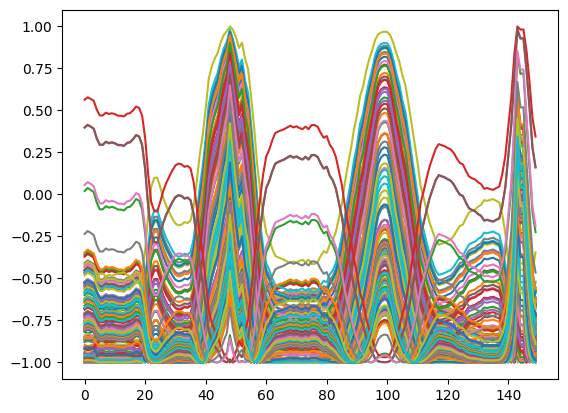

In [12]:
!pip install pyts
from pyts.image import GramianAngularField

def transform_to_gasf(series):
    normalized_series = (series - np.min(series)) / (np.max(series) - np.min(series))
    gasf_transformer = GramianAngularField(image_size=normalized_series.shape[0], method='summation')
    gasf_image = gasf_transformer.fit_transform(normalized_series.reshape(1, -1))
    return gasf_image[0]

# Transform the entire dataset
X_train_gasf = np.array([transform_to_gasf(sample[0, :]) for sample in X_train])
X_test_gasf = np.array([transform_to_gasf(sample[0, :]) for sample in X_test])
print(X_train_gasf.shape , X_test_gasf.shape)
plt.plot(X_train_gasf[0])

In [13]:
class PositionEmbedding(layers.Layer):
    def __init__(self, num_patches, d_model):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = self.add_weight("pos_emb", shape=(1, num_patches, d_model))

    def call(self, x):
        return x + self.pos_emb

class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.mlp = keras.Sequential([
            layers.Dense(mlp_dim, activation='relu'),
            layers.Dense(d_model),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)
        mlp_output = self.mlp(out1)
        mlp_output = self.dropout2(mlp_output, training=training)
        return self.norm2(out1 + mlp_output)
class PatchEncoder(layers.Layer):
    def __init__(self, patch_size, num_patches, d_model):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.d_model = d_model
        self.proj = layers.Dense(d_model)

    def call(self, images):
        batch_size = tf.shape(images)[0]
        # Extraction des patchs
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )

        patch_dim = self.patch_size * self.patch_size * images.shape[-1]  # `images.shape[-1]` est le nombre de canaux
        # Aplatit les patchs et assurez-vous que la dernière dimension est correctement spécifiée
        flat_patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dim])
        # Projet les patchs aplatis dans l'espace d'embedding
        return self.proj(flat_patches)



def build_vit_model(image_size, patch_size, num_patches, num_layers, d_model, num_heads, mlp_dim, channels=3, num_classes=10):
    inputs = keras.Input(shape=(image_size, image_size, channels))
    # Prétraitement et découpage en patchs + projection
    patches = PatchEncoder(patch_size, num_patches, d_model)(inputs)

    # Ajout de Position Embedding
    sequence = PositionEmbedding(num_patches, d_model)(patches)

    # Transformer Blocks
    for _ in range(num_layers):
        sequence = TransformerBlock(d_model, num_heads, mlp_dim)(sequence)

    # Token de classification ou moyenne pour la classification
    representation = layers.GlobalAveragePooling1D()(sequence)
    # Couche de sortie
    outputs = layers.Dense(num_classes, activation="softmax")(representation)

    return keras.Model(inputs=inputs, outputs=outputs)





In [14]:

input_shape = X_train_gasf.size
image_size = X_train_gasf.shape[1]
patch_size = 10  # La taille des patchs (4x4, donc chaque image est divisée en 8x8 patchs)
num_patches = (image_size // patch_size) ** 2  # Le nombre de patchs par image
num_layers = 4  # Le nombre de blocs Transformer dans le modèle
d_model = 64  # La dimensionnalité des embeddings de patchs
num_heads = 4  # Le nombre de têtes d'attention dans chaque bloc Transformer
mlp_dim = 128  # La dimension du réseau feed-forward à l'intérieur des blocs Transformer
channels = 3  # Le nombre de canaux dans les images d'entrée
num_classes = 2

vit_model = build_vit_model(
    image_size=image_size,
    patch_size=patch_size,
    num_patches=num_patches,
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    channels=channels,
    num_classes=num_classes
)

# Compilation du modèle
vit_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Affichage du résumé du modèle
vit_model.summary()
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-5
)


callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
callbacks.append(reduce_lr)

history=model.fit(
    X_train_gasf,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
)

model.evaluate(X_test_gasf, y_test, verbose=1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 patch_encoder (PatchEncode  (None, 225, 64)           19264     
 r)                                                              
                                                                 
 position_embedding (Positi  (None, 225, 64)           14400     
 onEmbedding)                                                    
                                                                 
 transformer_block (Transfo  (None, 225, 64)           83200     
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, 225, 64)           83200     
 formerBlock)                                              

[0.10738646984100342, 0.9750000238418579]

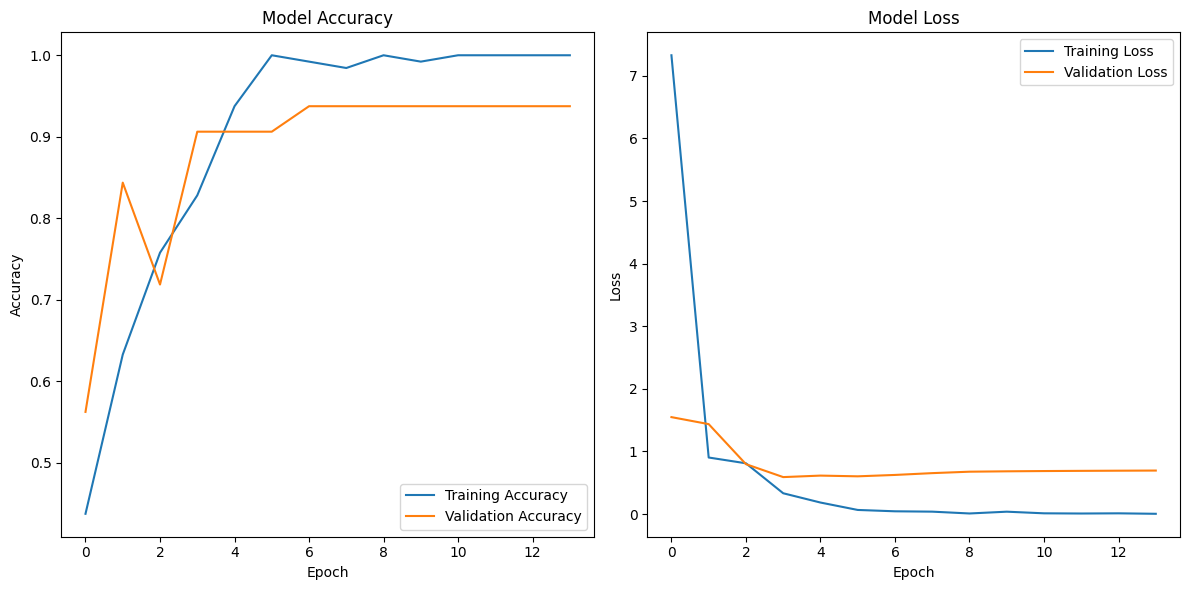

In [15]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

**Unbalanced Time series**

In [16]:
X_train_reduced, y_train_reduced = gpds[2], gpds[-1]
X_train_reduced.shape, y_train_reduced.shape

((88, 1, 150), (88,))

In [17]:

input_shape = X_train_reduced.shape[1:]

model = build_model(
    input_shape=input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    n_classes=2
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
callbacks.append(reduce_lr)
model.fit(
    X_train_reduced,
    y_train_reduced,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
)

model.evaluate(X_test, y_test, verbose=1)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1, 150)]             0         []                            
                                                                                                  
 layer_normalization_16 (La  (None, 1, 150)               300       ['input_3[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_8 (Mu  (None, 1, 150)               617622    ['layer_normalization_16[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_16

[1.0119335651397705, 0.5]

In [18]:
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 19ms/step - loss: 1.0119 - accuracy: 0.5000


[1.0119335651397705, 0.5]

In [19]:
#SMOTE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_reduced.reshape(X_train_reduced.shape[0],X_train_reduced.shape[-1]), y_train_reduced)


X_train_smote_norm = scaler.fit_transform(X_train_smote)
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0],X_test.shape[-1]))
X_train_smote_norm = X_train_smote_norm.reshape(X_train_smote_norm.shape[0],X_train_smote_norm.shape[-1],1)
X_test_norm = X_test_norm.reshape(X_test.shape[0],X_test.shape[-1],1)
print(X_train_smote_norm.shape, X_test_norm.shape)
y_train_smote.sum()

(160, 150, 1) (40, 150, 1)


80

In [20]:

input_shape = X_train_smote_norm.shape[1:]

model = build_model(
    input_shape=input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    n_classes=2
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
callbacks.append(reduce_lr)
model.fit(
    X_train_smote_norm,
    y_train_smote,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
)

model.evaluate(X_test_norm, y_test, verbose=1)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 1)]             0         []                            
                                                                                                  
 layer_normalization_24 (La  (None, 150, 1)               2         ['input_4[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_12 (M  (None, 150, 1)               7169      ['layer_normalization_24[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_24

[0.707858681678772, 0.375]

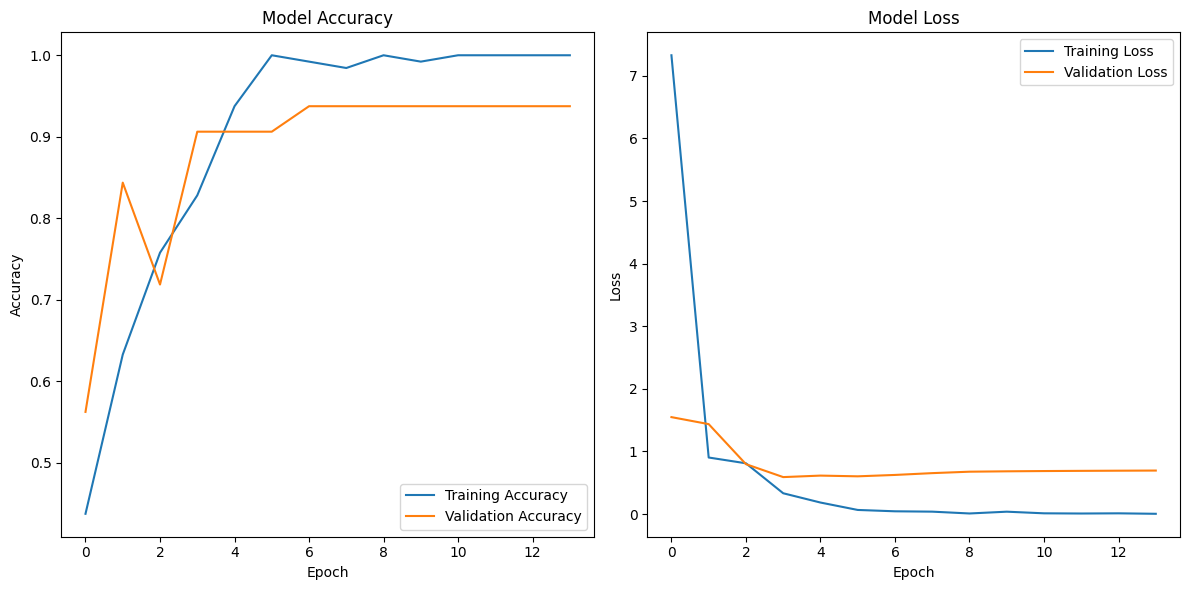

In [21]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

**Les images reconstruites de Florine**

In [73]:
import numpy as np


images_path = '/content/reconstructed_images.npy'
labels_path = '/content/labels-6.npy'

images = np.load(images_path)
labels = np.load(labels_path)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print (labels)

Images shape: (16, 1, 150, 150)
Labels shape: (16,)
[1 1 1 1 1 2 1 2 1 1 1 1 2 2 1 1]


In [74]:
from sklearn.model_selection import train_test_split

X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(images, labels, test_size=0.2, random_state=42)


In [75]:
from collections import Counter

# Compter le nombre d'exemples par classe dans l'ensemble existant
existing_labels_count = Counter(y_train_reduced)

In [76]:
existing_labels_count

Counter({1: 80, 0: 8})

In [77]:
# Objectif : avoir autant d'exemples pour la classe 0 que pour la classe 1
target_count = existing_labels_count[1]  # Nombre cible d'exemples pour la classe 0
shortfall = target_count - existing_labels_count[0]  # Calcul du déficit pour la classe 0
print(shortfall)


72


In [78]:
print(images)

[[[[0.60443634 0.60443634 0.60443634 ... 0.61278486 0.50068635
    0.50068635]
   [0.60443634 0.60443634 0.60443634 ... 0.61278486 0.50068635
    0.50068635]
   [0.60443634 0.60443634 0.60443634 ... 0.61278486 0.50068635
    0.50068635]
   ...
   [0.6273489  0.6273489  0.6273489  ... 0.5153858  0.5189752
    0.5189752 ]
   [0.60780245 0.60780245 0.60780245 ... 0.52138066 0.43010074
    0.43010074]
   [0.60780245 0.60780245 0.60780245 ... 0.52138066 0.43010074
    0.43010074]]]


 [[[0.49699557 0.49699557 0.49699557 ... 0.5546307  0.42339462
    0.42339462]
   [0.49699557 0.49699557 0.49699557 ... 0.5546307  0.42339462
    0.42339462]
   [0.49699557 0.49699557 0.49699557 ... 0.5546307  0.42339462
    0.42339462]
   ...
   [0.5716325  0.5716325  0.5716325  ... 0.5976295  0.6079575
    0.6079575 ]
   [0.5612586  0.5612586  0.5612586  ... 0.53126657 0.43675733
    0.43675733]
   [0.5612586  0.5612586  0.5612586  ... 0.53126657 0.43675733
    0.43675733]]]


 [[[0.3616495  0.3616495  0.3616

In [79]:

labels-=1
print(labels)

[0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0]


Nombre initial d'images de la classe 0 : 12
Nombre d'exemples par classe dans le nouvel ensemble : Counter({0: 24, 1: 4})


In [65]:
gen_images_class_0 = images[labels== 0] #pour la classe minoritaire
gen_labels_class_0 = labels[labels ==0]

In [66]:
print(len(gen_labels_class_0))

12


In [67]:

num_gen_images_to_add = min(72, len(gen_images_class_0))

selected_gen_images = gen_images_class_0[:num_gen_images_to_add]
selected_gen_labels = gen_labels_class_0[:num_gen_images_to_add]


In [81]:
# Fusionner les ensembles de données
new_images = np.concatenate((images, selected_gen_images), axis=0)
new_labels = np.concatenate((y_train_reduced, selected_gen_labels), axis=0)
print(new_labels)


[0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [69]:
from sklearn.utils import shuffle

new_images, new_labels = shuffle(new_images, new_labels, random_state=42)


In [70]:
from collections import Counter

# Compter le nombre d'exemples par classe dans l'ensemble existant
existing_labels_count = Counter(y_train_reduced)

In [71]:
print(existing_labels_count)

Counter({1: 80, 0: 8})


In [72]:
import numpy as np

if new_labels.ndim > 1:
    new_labels_scalar = np.argmax(new_labels, axis=1)
else:
    new_labels_scalar = new_labels

# Compter les occurrences de chaque classe
unique, counts = np.unique(new_labels_scalar, return_counts=True)
class_counts = dict(zip(unique, counts))

print("Nombre d'exemples par classe :", class_counts)


Nombre d'exemples par classe : {0: 24, 1: 4}
